Temperature is:  32.16 C
DAC7 Set to mid-scale, readback is: 2048
IO[2..6] Set as output high
GPIO Write Config Register readback: 0x7C
GPIO read state: 0x00
ADC0 result is: 0.01 V


<IPython.core.display.Javascript object>


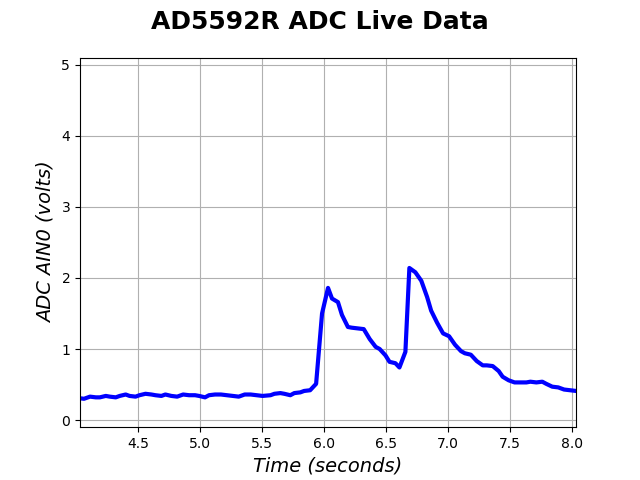

<IPython.core.display.Javascript object>


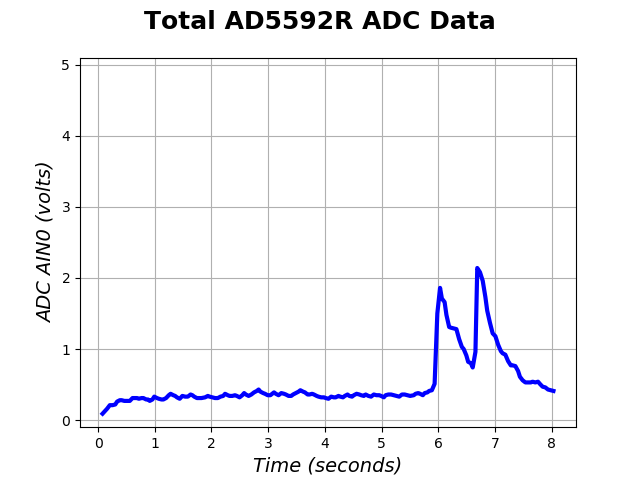

In [1]:
#
# AnalogMax: AD5592R ADC/DAC/GPIO Demo
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time

#
# Please change here to proper COM port name
#
ser = serial.Serial('COM5', 115200)
#
# 
#
ADC_GAIN = 1 # Default Gain is 1 after reset/poweron
#
# AD5592 register access functions
#
def AD5592_write_reg(reg, value):
    cmd = "<%0.4x>" % ((reg << 11) + (value & 0xfff))  # 
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
#
def AD5592_write_dac(dac, value):
    cmd = "<%0.4x>" % ((dac << 12) + (value & 0xfff) | 0x8000)  # 
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
#
def AD5592_read16():
    ser.reset_input_buffer()
    ser.write(b'<....>')   # Read result, (scan-in NOP)
    s = ser.read(4)        # Read two data bytes
    return int(s,16)       # Convert hex to int
    
#
# Temperature(C) = 25 + (ADC - 820/Gain)/2.654
#
def AD5592_get_temperature():
    # Get result, assume that temp channel is enabled!
    t = AD5592_read16() & 0xfff # Strip Channel bits
    t = 25 + (t - 820/ADC_GAIN)/2.654
    return round(t,2)    
#
def AD5592_get_adc():
    # Get result, assume that single ADC channel is enabled!
    t = ADC_GAIN*2.5*(AD5592_read16() & 0xfff)/4096 # Strip Channel bits
    return round(t,2)    


ser.flushInput() # flush the serial input buffer
ser.reset_input_buffer() # reset the serial input buffer

ser.write(b'[2]')    # Select UHSA AD5592 Channel
#
# Issue Software Reset first
#
AD5592_write_reg(0xf, 0xdac) # Soft Reset MAGIC

# General-Purpose Control
AD5592_write_reg(3, 0x30)   # ADC and DAC range VREF*2
ADC_GAIN = 2            # Change gain for calculations  
#
# Configure ADC for repeated Temperature Readings
#

# Power Down/Ref control: enable intref
AD5592_write_reg(0x0b, 0x200)
# ADC SEQUENCE: REP, Temperature
AD5592_write_reg(0x2, 0x300)
   
# diagnostics
print("Temperature is: ", AD5592_get_temperature(), "C")

AD5592_write_reg(0x2, 0)  # ADC SEQUENCE: none

#
# DAC7
#
AD5592_write_reg(0x5, 0x80) # IO7 to DAC
AD5592_write_dac(7, 2048)   # DAC7 mid-scale = 2.5V
#
AD5592_write_reg(0x1, 0x18 | 7) # DAC7 readback
print("DAC7 Set to mid-scale, readback is:", AD5592_read16() & 0xfff)  # NOTE: disable ADC sequence!
#
# GPIO
#
AD5592_write_reg(0x6, 0x00)   # pulldown mode set to OFF
AD5592_write_reg(0x8, 0x7c)   # IO2..6 as GPIO Output
AD5592_write_reg(0x9, 0xff)   # GPIO Output register to all 1's
print("IO[2..6] Set as output high")

AD5592_write_reg(0x7, 0x60) # Readback GPIO Write Config
x = AD5592_read16()
print("GPIO Write Config Register readback:", "0x%0.2X" % (x & 0xff))  # NOTE: disable ADC sequence!

# GPIO input
AD5592_write_reg(0xa,         0x02)  # GPIO Read Config, IO1 is input
AD5592_write_reg(0xa, 0x400 | 0x02)  # GPIO Read Config, IO1 is input, enable readback
x = AD5592_read16()

# diagnostics
print("GPIO read state:", "0x%0.2X" % (x & 0xff))  # NOTE: disable ADC sequence!

#
# ADC0
#
AD5592_write_reg(4, 0x01)  # ADC Config: enable IO0
AD5592_write_reg(2, 0x01 | 0x200)  # ADC SEQUENCE: ADC0, Repeat
   
print("ADC0 result is:", AD5592_get_adc(), "V")

#
# plot ADC0 input
#
plt.ion() 
start_time = time()
timepoints = []
ydata = []

yrange = [-0.1,5.1] # y plot range
view_time = 4 # seconds of data to view at once
duration = 8 # total seconds to collect data

# moving window plot configuration
fig1 = plt.figure()
fig1.suptitle('AD5592R ADC Live Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('ADC AIN0 (volts)', fontsize='14', fontstyle='italic')

# plot data
line1, = plt.plot(timepoints, ydata, color="blue", linewidth=3.0)

# set x and y plot axis range
plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # flush the serial input buffer

# set run boolean to 'true' to enable data capture and plotting
run = True

# collect the data and plot a moving frame
while run:
    # 
    try:
        # get ADC AIN0 data
        y = AD5592_get_adc()

        # store the entire dataset for later
        ydata.append(y)
        
        # update time for x axis plot
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted data
        line1.set_xdata(timepoints)
        line1.set_ydata(ydata)
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect+plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()
    
# plot of total data collected
fig2 = plt.figure()
fig2.suptitle('Total AD5592R ADC Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('ADC AIN0 (volts)', fontsize='14', fontstyle='italic')

# plot total data
plt.plot(timepoints, ydata, color="blue", linewidth=3.0)

# set y axis limits and show plot
plt.ylim(yrange)
fig2.show()

# close serial port after completion
ser.close()
